In [100]:
import pandas as pd
import numpy as np
from pathlib import Path
# 1. Load dataset
path = Path(r"C:\Users\shawn\Desktop\Pandas1\My project 2\Uncleaned_employees_final_dataset.csv")
df = pd.read_csv(path)
# Show initial shape and first 5 rows
print("Initial shape (rows, cols):", df.shape)
print("\nFirst 5 rows:")
display(df.head())
# 2. Normalize column names: strip, lower, replace spaces and special chars with underscores
orig_columns = df.columns.tolist()
df.columns = [str(col).strip().lower().replace(" ", "_").replace("-", "_") for col in df.columns]
print("\nOriginal columns:")
print(orig_columns)
print("\nNormalized columns:")
print(df.columns.tolist())
# 3. Basic info & missing values
print("\n--- DataFrame info ---")
display(df.info())
print("\nMissing values (count per column):")
missing_counts = df.isnull().sum().sort_values(ascending=False)
display(missing_counts)
# Also show percent missing
missing_percent = (df.isnull().mean() * 100).sort_values(ascending=False)
print("\nMissing values (percent per column):")
display(missing_percent.round(2))
# 4. Drop exact duplicates (if any)
before_dup = df.shape[0]
df = df.drop_duplicates()
after_dup = df.shape[0]
print(f"\nDropped {before_dup - after_dup} exact duplicate rows.")
# 5. Trim whitespace in object/string columns
obj_cols = df.select_dtypes(include="object").columns.tolist()
for col in obj_cols:
    # Only apply strip if column is not all NaN
    if df[col].notna().any():
        df[col] = df[col].astype(str).str.strip().replace({"nan": np.nan})

print(f"\nTrimmed whitespace for {len(obj_cols)} object columns.")
# 6. Attempt to parse date columns (columns containing 'date' or 'joined' or 'dob' or 'hire')
date_hints = ["date", "joined", "dob", "hire", "start"]
for col in df.columns:
    if any(hint in col for hint in date_hints):
        try:
            df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=False)
            print(f"Parsed dates in column: {col}")
        except Exception as e:
            print(f"Could not parse dates in {col}: {e}")
# 7. Convert numeric-looking object columns to numeric
for col in df.columns:
    if df[col].dtype == "object":
        # try to coerce to numeric
        coerced = pd.to_numeric(df[col].str.replace(",", "").str.replace("%", ""), errors="coerce")
        # If substantial conversion happened, replace the column
        non_null_before = df[col].notna().sum()
        non_null_after = coerced.notna().sum()
        if non_null_after >= max(1, non_null_before * 0.2):  # at least some conversions
            df[col] = coerced
            print(f"Converted column to numeric where possible: {col} ({non_null_after}/{non_null_before} non-null numeric)")
# 8. Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nNumeric columns detected:", numeric_cols)
print("Categorical/object columns detected:", cat_cols)
# 9. Impute missing values
# Numeric -> median; Categorical -> mode if exists else 'Unknown'
for col in numeric_cols:
    median = df[col].median()
    if pd.isna(median):
        # if entire column is NaN, leave as is
        continue
    df[col] = df[col].fillna(median)
    print(f"Filled NaNs in numeric column '{col}' with median: {median}")
for col in cat_cols:
    if df[col].isnull().all():
        df[col] = df[col].fillna("Unknown")
        print(f"Column '{col}' entirely NaN. Filled with 'Unknown'.")
    else:
        mode_vals = df[col].mode(dropna=True)
        if not mode_vals.empty:
            mode_val = mode_vals.iloc[0]
            df[col] = df[col].fillna(mode_val)
            print(f"Filled NaNs in categorical column '{col}' with mode: {mode_val}")
        else:
            df[col] = df[col].fillna("Unknown")
            print(f"Filled NaNs in categorical column '{col}' with 'Unknown' (no mode found).")
# 10. Handle outliers in numeric columns using IQR capping (1.5*IQR)
def cap_outliers(series):
    if series.dropna().empty:
        return series
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

for col in numeric_cols:
    before_min, before_max = df[col].min(), df[col].max()
    df[col] = cap_outliers(df[col])
    after_min, after_max = df[col].min(), df[col].max()
    if (before_min, before_max) != (after_min, after_max):
        print(f"Capped outliers in '{col}': min {before_min}->{after_min}, max {before_max}->{after_max}")
# 11. Create a small derived column example: tenure in years if 'hire_date' or similar exists
possible_hire_cols = [c for c in df.columns if any(h in c for h in ["hire", "joined", "start", "date_of_join", "date_joined", "date"])]
if possible_hire_cols:
    # pick the first datetime column detected
    hire_col = None
    for c in possible_hire_cols:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            hire_col = c
            break
    if hire_col:
        ref_date = pd.Timestamp("today")
        df["tenure_years"] = ((ref_date - df[hire_col]).dt.days / 365).round(2)
        print(f"Added 'tenure_years' derived from '{hire_col}' using reference date {ref_date.date()}.")
# 12. Final check
print("\nFinal shape (rows, cols):", df.shape)
print("\nCleaned DataFrame preview:")
display(df.head())
# 13. Save cleaned CSV
from pathlib import Path

output_path = Path(r"C:\Users\shawn\Desktop\Pandas1\My project 2\cleaned_employees_final_dataset.csv")

df.to_csv(output_path, index=False)

print(f"Saved cleaned CSV to: {output_path}")




Initial shape (rows, cols): (17417, 13)

First 5 rows:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61



Original columns:
['employee_id', 'department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met_more_than_80', 'awards_won', 'avg_training_score']

Normalized columns:
['employee_id', 'department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'kpis_met_more_than_80', 'awards_won', 'avg_training_score']

--- DataFrame info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17417 entries, 0 to 17416
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employee_id            17417 non-null  int64  
 1   department             17417 non-null  object 
 2   region                 17417 non-null  object 
 3   education              16646 non-null  object 
 4   gender                 17417 non-null  object 
 5   recruitment_channel   

None


Missing values (count per column):


previous_year_rating     1363
education                 771
employee_id                 0
region                      0
department                  0
gender                      0
recruitment_channel         0
no_of_trainings             0
age                         0
length_of_service           0
kpis_met_more_than_80       0
awards_won                  0
avg_training_score          0
dtype: int64


Missing values (percent per column):


previous_year_rating     7.83
education                4.43
employee_id              0.00
region                   0.00
department               0.00
gender                   0.00
recruitment_channel      0.00
no_of_trainings          0.00
age                      0.00
length_of_service        0.00
kpis_met_more_than_80    0.00
awards_won               0.00
avg_training_score       0.00
dtype: float64


Dropped 2 exact duplicate rows.

Trimmed whitespace for 5 object columns.

Numeric columns detected: ['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'kpis_met_more_than_80', 'awards_won', 'avg_training_score']
Categorical/object columns detected: ['department', 'region', 'education', 'gender', 'recruitment_channel']
Filled NaNs in numeric column 'employee_id' with median: 39115.0
Filled NaNs in numeric column 'no_of_trainings' with median: 1.0
Filled NaNs in numeric column 'age' with median: 33.0
Filled NaNs in numeric column 'previous_year_rating' with median: 3.0
Filled NaNs in numeric column 'length_of_service' with median: 5.0
Filled NaNs in numeric column 'kpis_met_more_than_80' with median: 0.0
Filled NaNs in numeric column 'awards_won' with median: 0.0
Filled NaNs in numeric column 'avg_training_score' with median: 60.0
Filled NaNs in categorical column 'department' with mode: Sales & Marketing
Filled NaNs in categorical column 'region' wi

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_more_than_80,awards_won,avg_training_score
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,3.0,1,1,0,77
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.5,4,0,0,47
3,38562,Procurement,region_2,Bachelors,f,other,1,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61


Saved cleaned CSV to: C:\Users\shawn\Desktop\Pandas1\My project 2\cleaned_employees_final_dataset.csv


<Axes: xlabel='department'>

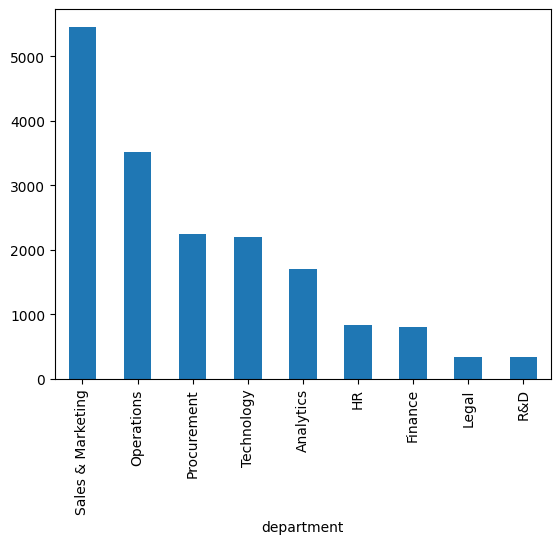

In [101]:
df['department'].value_counts().plot(kind='bar')


SALES AND MARKETING DEPARTMENT HAS MORE MEMBERS


<Axes: xlabel='gender'>

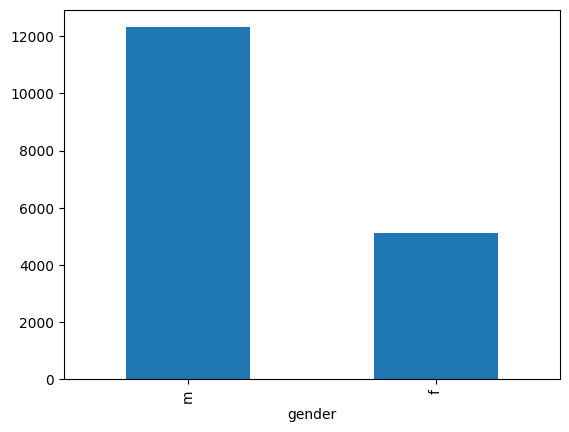

In [102]:
df['gender'].value_counts().plot(kind='bar')

MOST COMMON GENDER IS MALE


<Axes: >

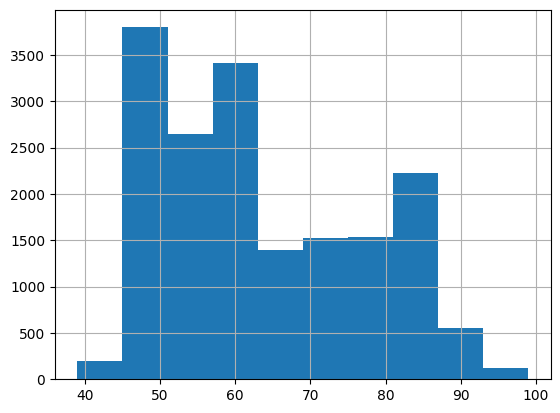

In [103]:
df['avg_training_score'].hist()

MOST EMPLOYEES HAVE SCORES BETWEEN 45 AND 60



<Axes: xlabel='kpis_met_more_than_80'>

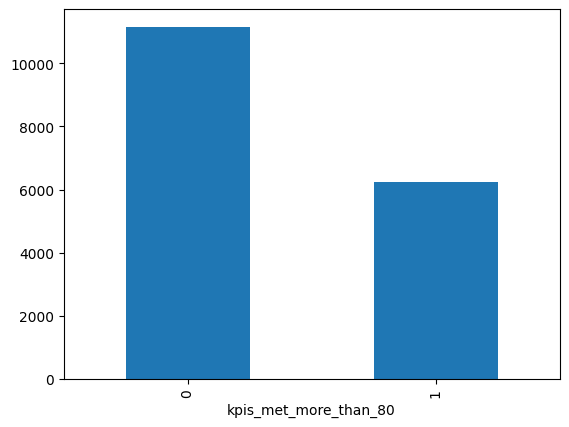

In [104]:
df['kpis_met_more_than_80'].value_counts().plot(kind='bar')

6000 PEOPLE HAVE THEIR KPI(KEY PWERFORMANCE) INDICATOR AT 1 (MEANS THEYRE SATISFACTORY)

In [105]:
df.groupby("department")["avg_training_score"].mean()
df.groupby("education")["kpis_met_more_than_80"].mean()
df.pivot_table(values='avg_training_score', index='department', columns='kpis_met_more_than_80')


kpis_met_more_than_80,0,1
department,,
Analytics,84.529470,84.618557
Finance,60.289855,60.382445
HR,49.994350,51.080000
Legal,59.794393,59.059322
Operations,60.491629,60.173857
Procurement,70.152422,70.227273
R&D,84.289617,84.651007
Sales & Marketing,49.870722,50.541309
Technology,79.746469,80.030651


Training Score vs KPI

In [106]:
df.groupby("awards_won")["kpis_met_more_than_80"].mean()


awards_won
0    0.358886
Name: kpis_met_more_than_80, dtype: float64

KPI vs Awards

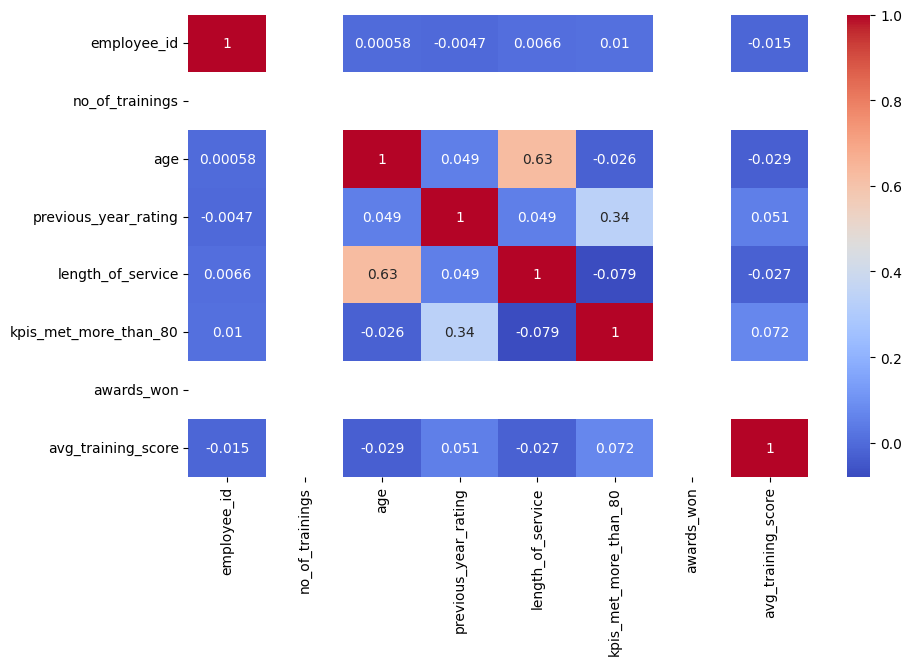

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.show()



This is a correlation heatmap of all numeric columns in this
dataset.

Correlation values range from:

+1 → strong positive relationship

–1 → strong negative relationship

0 → no relationship

In [108]:
df["high_training_score"] = df["avg_training_score"] > 80


In [109]:
df["performance_level"] = df["kpis_met_more_than_80"].apply(lambda x: "High" if x==1 else "Low")


In [110]:
import pandas as pd

# Load your CSV
df = pd.read_csv(r"C:\Users\shawn\Desktop\Pandas1\My project 2\cleaned_employees_final_dataset.csv")

# Strip whitespace and hidden characters from column names
df.columns = df.columns.str.strip()       # removes spaces
df.columns = df.columns.str.replace('\t','', regex=False)  # remove tabs
df.columns = df.columns.str.replace('\r','', regex=False)  # remove carriage return
df.columns = df.columns.str.replace('\n','', regex=False)  # remove newlines

# Drop duplicate column names if any still exist
df = df.loc[:, ~df.columns.duplicated()]

# Save a clean version
df.to_csv(r"C:\Users\shawn\Desktop\Pandas1\My project 2\cleaned_fixed.csv", index=False)

print(df.columns)
print("Saved cleaned_fixed.csv successfully")


Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpis_met_more_than_80', 'awards_won',
       'avg_training_score'],
      dtype='object')
Saved cleaned_fixed.csv successfully
